<div align="center"> 
    <hr>
  <font size="6"><b>Dev | Dirty Entity Resolution Notebook</b> </font>
   <hr>
</div>

In [35]:
import os
import sys
import pandas as pd
import networkx
from networkx import (
    draw,
    DiGraph,
    Graph,
)

%load_ext autoreload
%autoreload 2
%reload_ext autoreload
from pyjedai.utils import print_clusters, print_blocks, print_candidate_pairs
from pyjedai.evaluation import Evaluation
from pyjedai.datamodel import Data

d1 = pd.read_csv("./data/der/cora/cora.csv", sep='|')
gt = pd.read_csv("./data/der/cora/cora_gt.csv", sep='|', header=None)
attr = ['Entity Id','author', 'title']
data = Data(
    dataset_1=d1,
    id_column_name_1='Entity Id',
    ground_truth=gt,
    attributes_1=attr
)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Block Building

In [14]:
from pyjedai.block_building import (
    StandardBlocking,
    QGramsBlocking,
    SuffixArraysBlocking,
    ExtendedSuffixArraysBlocking,
    ExtendedQGramsBlocking
)

In [17]:
blocks = StandardBlocking().build_blocks(data)

Standard Blocking:   0%|          | 0/1295 [00:00<?, ?it/s]

#### EmbeddingsNNBlockBuilding

In [ ]:
from pyjedai.vector_based_blocking import EmbeddingsNNBlockBuilding

emb = EmbeddingsNNBlockBuilding(
    vectorizer='bert',
    similarity_search='faiss'
)
blocks = emb.build_blocks(data)

In [ ]:
emb.evaluate(blocks)

### Block Cleaning

In [18]:
from pyjedai.block_cleaning import BlockFiltering

In [19]:
bf = BlockFiltering(ratio=0.9)
filtered_blocks = bf.process(blocks, data)

Block Filtering:   0%|          | 0/3 [00:00<?, ?it/s]

In [20]:
bf.evaluate(filtered_blocks, with_classification_report=True)

***************************************************************************************************************************
                                         Μethod:  Block Filtering
***************************************************************************************************************************
Method name: Block Filtering
Parameters: 
	Ratio: 0.9
Runtime: 0.0417 seconds
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Performance:
	Precision:      0.81% 
	Recall:        99.91%
	F1-score:       1.60%
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Classification report:
	True positives: 17169
	False positives: 2107952
	True negatives: -1270102
	False negatives: 15
	Total comparisons: 2125121
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


{'Precision %': 0.8079069380049418,
 'Recall %': 99.9127094972067,
 'F1 %': 1.6028530017901284,
 'True Positives': 17169,
 'False Positives': 2107952.0,
 'True Negatives': -1270102.0,
 'False Negatives': 15}

### Comparison Cleaning - Meta Blocking

In [21]:
from pyjedai.block_cleaning import BlockPurging

In [22]:
bp = BlockPurging(
    smoothing_factor=0.008
)
cleaned_blocks = bp.process(blocks, data)

Block Purging:   0%|          | 0/850 [00:00<?, ?it/s]

In [23]:
bp.evaluate(cleaned_blocks)

***************************************************************************************************************************
                                         Μethod:  Block Purging
***************************************************************************************************************************
Method name: Block Purging
Parameters: 
	Smoothing factor: 0.008
	Max Comparisons per Block: 6.0
Runtime: 0.0303 seconds
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Performance:
	Precision:     33.88% 
	Recall:         0.61%
	F1-score:       1.19%
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


{'Precision %': 33.876221498371336,
 'Recall %': 0.6052141527001862,
 'F1 %': 1.189183008404322,
 'True Positives': 104,
 'False Positives': 203.0,
 'True Negatives': 820582.0,
 'False Negatives': 17080}

In [24]:
from pyjedai.comparison_cleaning import (
    WeightedEdgePruning,
    WeightedNodePruning,
    CardinalityEdgePruning,
    CardinalityNodePruning,
    BLAST,
    ReciprocalCardinalityNodePruning,
    # ReciprocalCardinalityWeightPruning,
    ComparisonPropagation
)

In [25]:
wep = WeightedEdgePruning(weighting_scheme='CBS')
candidate_pairs_blocks = wep.process(filtered_blocks, data)

Weighted Edge Pruning:   0%|          | 0/1295 [00:00<?, ?it/s]

In [26]:
wep.evaluate(candidate_pairs_blocks)

***************************************************************************************************************************
                                         Μethod:  Weighted Edge Pruning
***************************************************************************************************************************
Method name: Weighted Edge Pruning
Parameters: 
	Node centric: False
	Weighting scheme: CBS
Runtime: 4.1564 seconds
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Performance:
	Precision:      4.77% 
	Recall:        99.30%
	F1-score:       9.09%
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


{'Precision %': 4.76517601327011,
 'Recall %': 99.30167597765363,
 'F1 %': 9.093961341071514,
 'True Positives': 17064,
 'False Positives': 341034,
 'True Negatives': 496711.0,
 'False Negatives': 120}

### Entity Matching

In [27]:
from pyjedai.matching import EntityMatching

In [28]:
attr = ['author', 'title']
# or with weights
attr = {
    'author' : 0.6,
    'title' : 0.4
}

EM = EntityMatching(
    metric='jaccard', 
    similarity_threshold=0.5
    # embedings=None, # gensim
    # attributes=attr,
    # qgram=2 # for ngram metric or jaccard
)

# pairs_graph = EM.predict(blocks, data)

In [29]:
pairs_graph = EM.predict(filtered_blocks, data)

Entity Matching (jaccard):   0%|          | 0/401 [00:00<?, ?it/s]

In [34]:
attr = {
    'author' : 0.6, 
    'title' : 0.4
}

EM = EntityMatching(
    metric='jaccard', 
    similarity_threshold=0.5,
    # embedings=None, # gensim
    attributes=attr,
    qgram=2 # for ngram metric or jaccard
)

pairs_graph = EM.predict(candidate_pairs_blocks, data)

Entity Matching (jaccard):   0%|          | 0/1289 [00:00<?, ?it/s]

In [ ]:
draw(pairs_graph)

In [ ]:
EM.evaluate(pairs_graph)

### Entity Clustering

In [31]:
from pyjedai.clustering import ConnectedComponentsClustering, UniqueMappingClustering

In [36]:
UMC = ConnectedComponentsClustering()
clusters = UMC.process(pairs_graph, data)

In [37]:
CCC = ConnectedComponentsClustering()
clusters = CCC.process(pairs_graph, data)

In [38]:
CCC.evaluate(clusters)

***************************************************************************************************************************
                                         Μethod:  Connected Components Clustering
***************************************************************************************************************************
Method name: Connected Components Clustering
Parameters: 
Runtime: 0.0329 seconds
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Performance:
	Precision:     79.77% 
	Recall:        68.69%
	F1-score:      73.81%
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


{'Precision %': 79.76616881800365,
 'Recall %': 68.68598696461825,
 'F1 %': 73.81257621712892,
 'True Positives': 11803,
 'False Positives': 2994.0,
 'True Negatives': 829490.0,
 'False Negatives': 5381}

# WorkFlow 2

### Similarity Joins

In [42]:
from pyjedai.joins import ΕJoin, TopKJoin

In [43]:
SAEJ = ΕJoin(
    similarity_threshold = 0.5,
    metric = 'jaccard',
    tokenization = 'qgrams_multiset',
    qgrams = 2
)
g = SAEJ.fit(data)

EJoin (jaccard):   0%|          | 0/2590 [00:00<?, ?it/s]

In [44]:
SAEJ.evaluate(g, with_classification_report=True)

***************************************************************************************************************************
                                         Μethod:  EJoin
***************************************************************************************************************************
Method name: EJoin
Parameters: 
	similarity_threshold: 0.5
	metric: jaccard
	tokenization: qgrams_multiset
	qgrams: 2
Runtime: 65.2521 seconds
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Performance:
	Precision:     65.80% 
	Recall:        93.03%
	F1-score:      77.08%
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Classification report:
	True positives: 15987
	False positives: 8311
	True negatives: 828357
	False negatives: 1197
	Total comparisons: 24298
────────────────────────────────────────────────────────────────────────────────

{'Precision %': 65.79553872746729,
 'Recall %': 93.03421787709497,
 'F1 %': 77.07921508124006,
 'True Positives': 15987,
 'False Positives': 8311,
 'True Negatives': 828357.0,
 'False Negatives': 1197}

In [45]:
TSAJ = TopKJoin(
    K=20,
    metric = 'jaccard',
    tokenization = 'qgrams',
    qgrams = 3
)
g = TSAJ.fit(data)

Top-K Join (jaccard):   0%|          | 0/2590 [00:00<?, ?it/s]

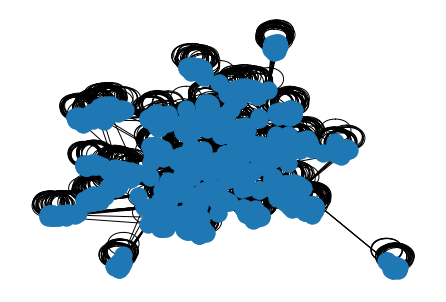

In [46]:
draw(g)

In [47]:
TSAJ.evaluate(g, with_classification_report=True)

***************************************************************************************************************************
                                         Μethod:  Top-K Join
***************************************************************************************************************************
Method name: Top-K Join
Parameters: 
	similarity_threshold: 0.25547445255474455
	K: 20
	metric: jaccard
	tokenization: qgrams
	qgrams: 3
Runtime: 21.1986 seconds
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Performance:
	Precision:     58.34% 
	Recall:        63.75%
	F1-score:      60.92%
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Classification report:
	True positives: 10954
	False positives: 7822
	True negatives: 823813
	False negatives: 6230
	Total comparisons: 18776
────────────────────────────────────────────────────────

{'Precision %': 58.340434597358325,
 'Recall %': 63.74534450651769,
 'F1 %': 60.923248053392655,
 'True Positives': 10954,
 'False Positives': 7822,
 'True Negatives': 823813.0,
 'False Negatives': 6230}

### Entity Clustering

In [48]:
from pyjedai.clustering import ConnectedComponentsClustering

In [49]:
CCC = ConnectedComponentsClustering()
clusters = CCC.process(g, data)

In [50]:
CCC.evaluate(clusters)

***************************************************************************************************************************
                                         Μethod:  Connected Components Clustering
***************************************************************************************************************************
Method name: Connected Components Clustering
Parameters: 
Runtime: 0.0481 seconds
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Performance:
	Precision:      2.05% 
	Recall:       100.00%
	F1-score:       4.02%
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


{'Precision %': 2.050927058655034,
 'Recall %': 100.0,
 'F1 %': 4.019418770152353,
 'True Positives': 17184,
 'False Positives': 820681.0,
 'True Negatives': 17184.0,
 'False Negatives': 0}